In [ ]:
# Remove old files if any
!rm -rf train2017 val2017 annotations train2017.zip val2017.zip annotations_trainval2017.zip

# Download COCO 2017 dataset
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# Unzip
!unzip -q train2017.zip
!unzip -q val2017.zip
!unzip -q annotations_trainval2017.zip


--2025-11-19 14:07:21--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.38.81, 16.15.191.201, 3.5.27.113, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.38.81|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  57.5MB/s    in 5m 38s  

2025-11-19 14:12:59 (54.6 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2025-11-19 14:12:59--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.15.217.138, 52.217.105.92, 54.231.235.17, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.15.217.138|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.8

In [ ]:
from pycocotools.coco import COCO
import os
import random
import numpy as np
from PIL import Image
from tqdm import tqdm

# Annotation file
annFile = "./annotations/instances_train2017.json"
coco = COCO(annFile)

# Sample 4000 images for quicker training
img_ids = coco.getImgIds()
selected_ids = random.sample(img_ids, 4000)

# Create folders for processed dataset
os.makedirs("dataset/images", exist_ok=True)
os.makedirs("dataset/masks", exist_ok=True)

# Generate images and binary masks
for img_id in tqdm(selected_ids, desc="Generating dataset"):
    info = coco.loadImgs(img_id)[0]
    img_path = f"./train2017/{info['file_name']}"
    image = np.array(Image.open(img_path).convert("RGB"))

    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    mask = np.zeros((info['height'], info['width']), dtype=np.uint8)
    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann))

    # Save image and mask
    Image.fromarray(image).save(f"dataset/images/{info['file_name']}")
    Image.fromarray(mask * 255).save(f"dataset/masks/{info['file_name'].replace('.jpg','.png')}")


loading annotations into memory...
Done (t=12.51s)
creating index...
index created!


Generating dataset: 100%|██████████| 4000/4000 [01:03<00:00, 62.96it/s]


In [ ]:
files = sorted(os.listdir("dataset/images"))
train_files = files[:3200]
val_files   = files[3200:]


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(p=0.3),
    A.Resize(512, 512),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(512, 512),
    ToTensorV2(),
])


In [ ]:
from torch.utils.data import Dataset
import cv2
import torch

class CocoSegDataset(Dataset):
    def __init__(self, files, transform):
        self.files = files
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]

        img = cv2.imread(f"dataset/images/{fname}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(f"dataset/masks/{fname.replace('.jpg', '.png')}", cv2.IMREAD_GRAYSCALE)
        mask = (mask > 128).astype("uint8")

        aug = self.transform(image=img, mask=mask)
        img = aug["image"].float() / 255.0
        mask = aug["mask"].unsqueeze(0).float()

        return img, mask


In [ ]:
from torch.utils.data import DataLoader

train_ds = CocoSegDataset(train_files, train_transform)
val_ds   = CocoSegDataset(val_files, val_transform)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)

print("Train samples:", len(train_ds), "| Validation samples:", len(val_ds))


Train samples: 3200 | Validation samples: 800


In [ ]:
!pip install segmentation-models-pytorch==0.3.3 albumentations==1.4.3 --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 52.7 MB/s eta 0:00:00


In [ ]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load U-Net
model = smp.Unet(
    encoder_name="resnet101",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,  # still 1 channel output
    activation=None
)

# ------------------ Unfreeze higher layers ------------------
for name, param in model.encoder.named_parameters():
    if "layer3" in name or "layer4" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# ------------------ Extra head ------------------
model.extra_head = nn.Sequential(
    nn.Conv2d(1, 64, 3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 32, 3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(32, 16, 3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(16, 1, 1)
)

# Modify forward
old_forward = model.forward
def new_forward(x):
    x = old_forward(x)
    x = model.extra_head(x)
    return x
model.forward = new_forward
model.to(device)


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


100%|██████████| 170M/170M [00:00<00:00, 354MB/s]


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
import torch.nn.functional as F

def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    inter = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2*inter + smooth) / (union + smooth)
    return 1 - dice.mean()

def combined_loss(pred, target):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    d   = dice_loss(pred, target)
    return 0.5*bce + 0.5*d


In [ ]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)


In [ ]:
from tqdm import tqdm

num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for imgs, masks in tqdm(train_loader):
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        preds = model(imgs)

        loss = combined_loss(preds, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    iou_total = 0
    count = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)

            val_loss += combined_loss(preds, masks).item()

            pr = (torch.sigmoid(preds) > 0.5).float()
            inter = (pr * masks).sum()
            union = ((pr + masks) > 0).float().sum()
            iou_total += (inter / (union + 1e-6)).item()
            count += 1

    avg_train = train_loss / len(train_loader)
    avg_val = val_loss / len(val_loader)
    avg_iou = iou_total / count

    scheduler.step(avg_val)

    print(f"Epoch {epoch+1}/{num_epochs} | Train={avg_train:.4f} | Val={avg_val:.4f} | IoU={avg_iou:.4f}")


100%|██████████| 400/400 [06:15<00:00,  1.06it/s]


Epoch 1/15 | Train=0.2336 | Val=0.2895 | IoU=0.6745


100%|██████████| 400/400 [06:14<00:00,  1.07it/s]


Epoch 2/15 | Train=0.2239 | Val=0.2889 | IoU=0.6778


100%|██████████| 400/400 [06:14<00:00,  1.07it/s]


Epoch 3/15 | Train=0.2193 | Val=0.2954 | IoU=0.6724


100%|██████████| 400/400 [06:14<00:00,  1.07it/s]


Epoch 4/15 | Train=0.2130 | Val=0.2885 | IoU=0.6750


100%|██████████| 400/400 [06:14<00:00,  1.07it/s]


Epoch 5/15 | Train=0.2128 | Val=0.2862 | IoU=0.6831


100%|██████████| 400/400 [06:15<00:00,  1.07it/s]


Epoch 6/15 | Train=0.2090 | Val=0.2913 | IoU=0.6793


100%|██████████| 400/400 [06:14<00:00,  1.07it/s]


Epoch 7/15 | Train=0.2088 | Val=0.2884 | IoU=0.6823


100%|██████████| 400/400 [06:14<00:00,  1.07it/s]


Epoch 8/15 | Train=0.2089 | Val=0.2894 | IoU=0.6805


100%|██████████| 400/400 [06:14<00:00,  1.07it/s]


Epoch 9/15 | Train=0.2098 | Val=0.2877 | IoU=0.6785


100%|██████████| 400/400 [06:14<00:00,  1.07it/s]


Epoch 10/15 | Train=0.2086 | Val=0.2894 | IoU=0.6787


100%|██████████| 400/400 [06:14<00:00,  1.07it/s]


Epoch 11/15 | Train=0.2112 | Val=0.2885 | IoU=0.6831


100%|██████████| 400/400 [06:14<00:00,  1.07it/s]


Epoch 12/15 | Train=0.2093 | Val=0.2909 | IoU=0.6781


 47%|████▋     | 187/400 [02:54<03:18,  1.07it/s]

In [ ]:
torch.save(model.state_dict(), "final_unet_resnet101_rgb.pth")
print("✅ Model saved!")


✅ Model saved!


IndexError: index 8 is out of bounds for axis 0 with size 8

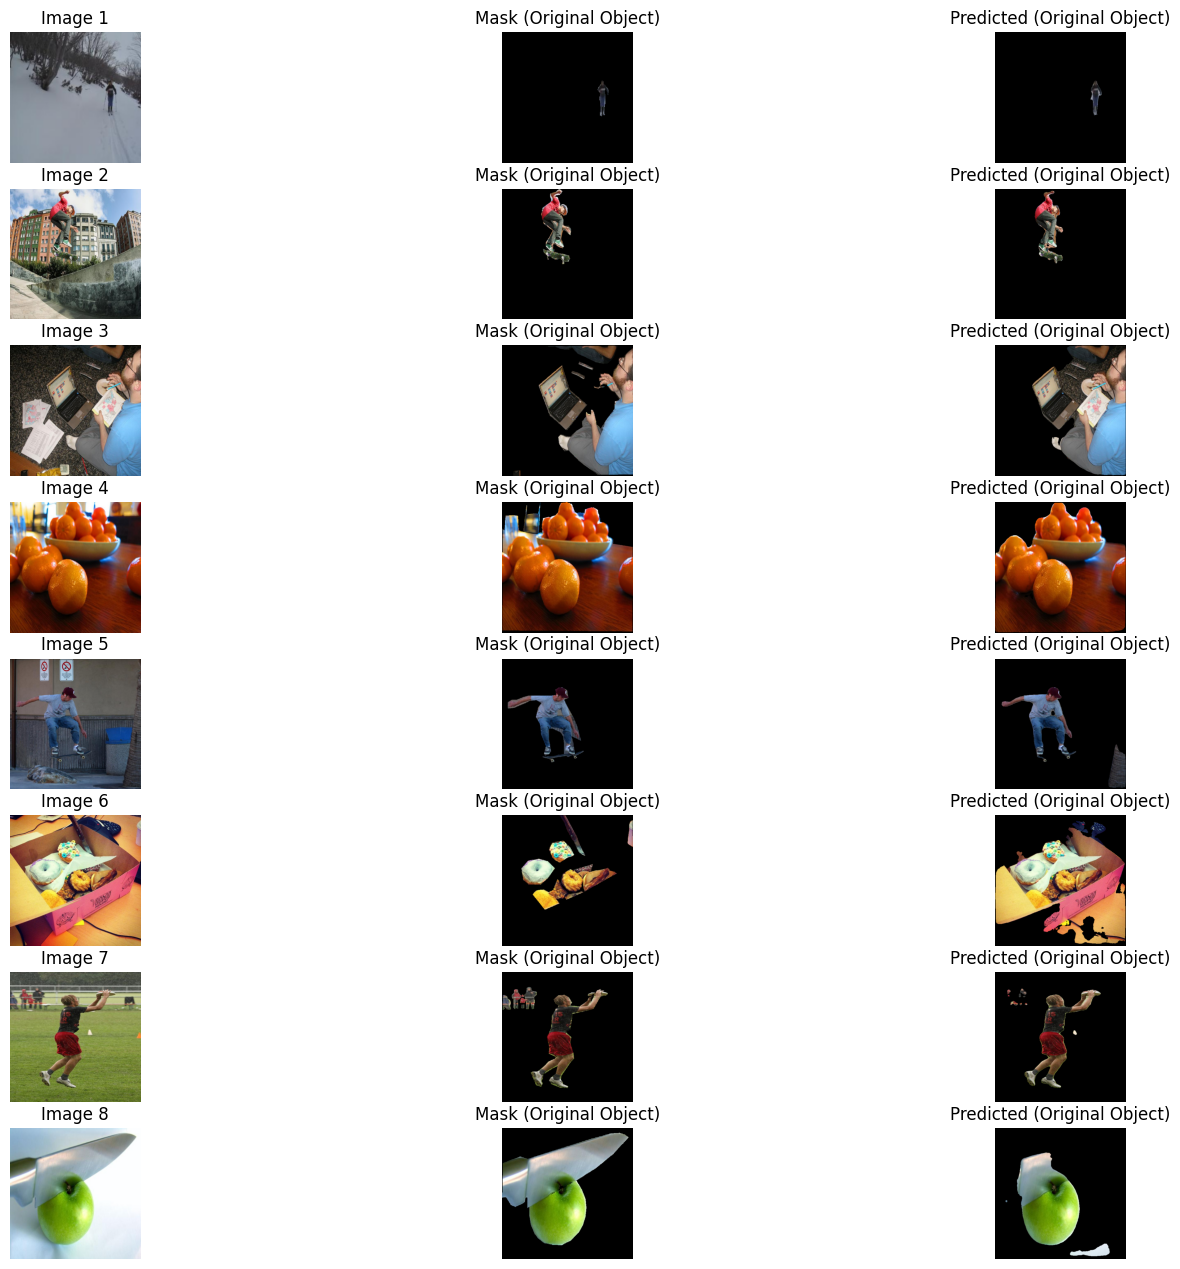

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

model.eval()
imgs, masks = next(iter(val_loader))
imgs, masks = imgs[:8].to(device), masks[:8].to(device)

preds = model(imgs)
preds = (torch.sigmoid(preds) > 0.5).float().cpu().numpy()
imgs_np = imgs.cpu().numpy()

plt.figure(figsize=(18, 20))  # Increased height to fit 10 images
for i in range(8):
    orig_img = np.transpose(imgs_np[i], (1,2,0))  # HWC

    # Predicted mask
    pred_mask = preds[i][0]  # HxW
    pred_mask_3c = np.repeat(pred_mask[:,:,None], 3, axis=2)  # HxWx3

    # Apply mask: original object stays, background black
    masked_pred_img = orig_img * pred_mask_3c

    # Ground truth mask
    gt_mask = masks[i][0].cpu().numpy()
    gt_mask_3c = np.repeat(gt_mask[:,:,None], 3, axis=2)
    masked_gt_img = orig_img * gt_mask_3c

    # ------------------- Plot -------------------
    plt.subplot(10,3,i*3+1)
    plt.imshow(orig_img)
    plt.title(f"Image {i+1}")
    plt.axis("off")

    plt.subplot(10,3,i*3+2)
    plt.imshow(masked_gt_img)
    plt.title("Mask (Original Object)")
    plt.axis("off")

    plt.subplot(10,3,i*3+3)
    plt.imshow(masked_pred_img)
    plt.title("Predicted (Original Object)")
    plt.axis("off")

plt.tight_layout()
plt.show()
